# Pollinator Detection – Starting Kit
---

Description of your challenge and instructions for challenge participants :

This notebook is the starting kit for the Pollinator Detection challenge. Its goal is to guide participants through the first steps of the project by demonstrating how to load the data, explore it, visualize examples, and build initial models using the provided tools.

The dataset used in this challenge consists of .h5 files, where each file contains a sequence of images and is associated with a binary label indicating the presence (1) or absence (0) of a pollinator. Throughout this notebook, each sequence is treated as a single data sample.

When running this notebook, the required data will be automatically downloaded if it is not already available locally.

This notebook is organized to progressively introduce the main components of the challenge:
- Data loading: how to access the dataset and configure memory usage or sampling size.
- Data exploration and visualization: how to inspect class distribution, visualize image sequences, and gain intuition about the data.
- Baseline modeling: simple examples illustrating how one might begin training and evaluating a model.
- Evaluation: an introduction to some appropriate metrics.

This notebook does not aim to provide a final or optimal solution. Instead, it serves as a reference implementation and learning tool to help participants understand the challenge and confidently begin developing their own approaches.

---

`COLAB` determines whether this notebook is running on Google Colab.

In [ ]:
COLAB = 'google.colab' in str(get_ipython())

In [ ]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/vladihnat/AI-Challenge-2025-26-Group-3-.git
    # move to the starting kit folder
    %cd AI-Challenge-2025-26-Group-3-/Starting_Kit/

# 0 - Imports & Settings

In [ ]:
import sys
import subprocess

libraries = {
    "xgboost": "xgboost",
    "skimage": "scikit-image", 
    "sklearn": "scikit-learn",
    "imblearn": "imbalanced-learn",
    "h5py": "h5py",
    "gdown": "gdown",
    "tqdm": "tqdm",
    "joblib": "joblib",
    "seaborn": "seaborn",
    "matplotlib": "matplotlib",
    "pandas": "pandas",
    "numpy": "numpy"
}

print("[*] Checking libraries...")

for import_name, install_name in libraries.items():
    try:
        __import__(import_name)
    except ImportError:
        print(f"[!] {import_name} not found. Installing {install_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", install_name])

print("[✔] All libraries are ready.")

In [1]:
import os
import gc
import datetime
import h5py
import gdown
import time
import zipfile
import random
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
from xgboost import XGBClassifier
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay, make_scorer
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from imblearn.over_sampling import SMOTE, RandomOverSampler
%matplotlib inline

# 1 - Data

## Description

This class provides an automated pipeline for handling the challenge datasets. It automatically downloads the train if it's not already present. It then load a fraction of the data, using a stratified slicing to keep the dataset intrisic proportion of both classes in the train and test set. The stratified slicing ensures that even when loading a small fraction of the data for fast prototyping, the rare "Visitor" class ratio (approx. 2.7%) is perfectly preserved. It offers a flexible memory management toggle, allowing users to choose between high-speed sequential RAM loading or memory-efficient direct-disk access.

## How to use it

Initialize: Create an instance by specifying your local data directory.

Load: Call load_data() with two key parameters:

sample_fraction: Set between 0.0 and 1.0 (e.g., 0.1 to load 10% for quick testing).

load_to_memory: Set to True for maximum speed (requires ~3GB RAM) or False if working on a machine with limited memory

Split: Call split_data() to get a training set and a test set. Since images are extracted from video sequences, we have to be careful when splitting, we can't split images from a same sequence in both the train and the test set (data leakage). We can't use a GroupSplit neither as it would yelds too different proportions of class 1 among both sets. We therefore propose you with a split function that respects the integrity of the sequences and try to finds the fairer split to have the same proportion of insects in both sets.

In [2]:
class Data:
    def __init__(self, data_dir="data"):
        self.data_dir = data_dir
        self.X_train, self.y_train = None, None
        self.X_test, self.y_test = None, None
        self.X_train_full = None
        self.y_train_full = None
        self.metadata_full = None 
        np.random.seed(42)
        
    def download_data(self):
        """Downloads files from Google Drive if not present."""
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)

        files = {
            "train_data.h5": "16o5myKPxvl8YcHejz_FQPEmZXn7Z9pA6",
            "train_labels.npy": "1mgvUrig6zwG84Thv0O63RiSc4JUUUUtQ",
            "train_metadata.npy": "1ybqiYqoun2q9q31YGWTRReEs8tnFTRv9", # Used for splitting with respect to sequences preventing leakage
        }

        for name, file_id in files.items():
            path = os.path.join(self.data_dir, name)
            if not os.path.exists(path) or os.path.getsize(path) < 100:
                print(f"[*] Downloading {name}...")
                url = f'https://drive.google.com/uc?id={file_id}'
                gdown.download(url, path, quiet=False)
            else:
                print(f"[OK] {name} is ready.")

    def load_data(self, sample_fraction=1.0, load_to_memory=True):
        """Loads data and metadata into memory."""
        self.download_data()
        print(f"[*] Loading data (fraction={sample_fraction*100}%)...")

        y_full = np.load(os.path.join(self.data_dir, "train_labels.npy"), allow_pickle=True)
        m_full = np.load(os.path.join(self.data_dir, "train_metadata.npy"), allow_pickle=True)
        
        idx_tr = None
        if sample_fraction < 1.0:
            idx_tr, _ = train_test_split(
                np.arange(len(y_full)), 
                train_size=sample_fraction, 
                stratify=y_full, 
                random_state=42
            )
            idx_tr = sorted(idx_tr)
            self.y_train_full = y_full[idx_tr]
            self.metadata_full = m_full[idx_tr]
        else:
            self.y_train_full = y_full
            self.metadata_full = m_full

        with h5py.File(os.path.join(self.data_dir, "train_data.h5"), "r") as f:
            print(f"[*] Extracting training images...")
            self.X_train_full = f["images"][idx_tr] if idx_tr is not None else f["images"][:]

    def split_data(self, test_size=0.25, search_duration=60):
        """
        In-memory Combinatorial Optimization Split (Greedy Search).
        Prevents leakage and optimizes class distribution.
        """
        print(f"[*] Starting Combinatorial Optimization Split ({search_duration}s)...")
        
        # 1. Group indices by sequence ID
        unique_groups = np.unique(self.metadata_full)
        group_map = {gid: np.where(self.metadata_full == gid)[0] for gid in unique_groups}
        
        # 2. Pre-calculate stats per group for speed
        group_stats = []
        global_pos = np.sum(self.y_train_full == 1)
        global_total = len(self.y_train_full)

        for gid, indices in group_map.items():
            group_stats.append({
                'id': gid,
                'indices': indices,
                'n1': np.sum(self.y_train_full[indices] == 1),
                'total': len(indices)
            })

        # 3. Greedy Search / Random Search Loop
        best_penalty = float('inf')
        best_test_idx = None
        start_time = time.time()
        iters = 0

        while (time.time() - start_time) < search_duration:
            iters += 1
            # Sample a subset of groups for the test set
            k = random.randint(max(1, int(len(unique_groups)*(test_size-0.05))), 
                               int(len(unique_groups)*(test_size+0.05)))
            current_test_groups = random.sample(group_stats, k)
            
            t1 = sum(g['n1'] for g in current_test_groups)
            tt = sum(g['total'] for g in current_test_groups)
            
            r1 = t1 / global_pos if global_pos > 0 else 0
            rt = tt / global_total
            
            # Penalty calculation (Target: test_size)
            p1 = abs(r1 - test_size) * 20 # Insect stock balance
            pt = abs(rt - test_size) * 5  # Total volume balance
            pl = abs(r1 - rt) * 10        # Distribution leakage
            
            total_penalty = p1 + pt + pl
            
            if total_penalty < best_penalty:
                best_penalty = total_penalty
                best_test_idx = np.concatenate([g['indices'] for g in current_test_groups])

        # 4. Finalize Split
        all_indices = np.arange(global_total)
        test_mask = np.zeros(global_total, dtype=bool)
        test_mask[best_test_idx] = True
        
        train_idx = all_indices[~test_mask]
        test_idx = all_indices[test_mask]

        self.X_train, self.X_test = self.X_train_full[train_idx], self.X_train_full[test_idx]
        self.y_train, self.y_test = self.y_train_full[train_idx], self.y_train_full[test_idx]

        # 5. Sanity Check Output
        print(f"[✔] Optimization completed ({iters} iterations).")
        self._print_split_stats(global_pos, global_total)

    def _print_split_stats(self, g_pos, g_total):
        for name, y in [("TRAIN", self.y_train), ("TEST", self.y_test)]:
            c1 = np.sum(y == 1)
            print(f"\n{name} SET:")
            print(f"  - Total Images:  {len(y)} ({100*len(y)/g_total:.1f}%)")
            print(f"  - Insect Images: {c1} ({100*c1/g_pos:.1f}%)")
            print(f"  - Ratio Class 1: {100*c1/len(y):.3f}%")

In [4]:
data_manager = Data(data_dir="data")

# sample_fraction=0.1 for quick testing (load 10% of data)
# Loading with load_to_memory=True requires ~3-4GB of free RAM (faster)
# Loading with load_to_memory=False is slower but more memory efficient
data_manager.load_data(sample_fraction=0.1, load_to_memory=True)

# About 2-5 minutes to download the data
# Less than 5 minutes to load the full data into memory with load_to_memory=True

# Split to create train and test set
data_manager.split_data(test_size=0.25, search_duration=60) 

[*] Downloading train_data.h5...


Downloading...
From (original): https://drive.google.com/uc?id=16o5myKPxvl8YcHejz_FQPEmZXn7Z9pA6
From (redirected): https://drive.google.com/uc?id=16o5myKPxvl8YcHejz_FQPEmZXn7Z9pA6&confirm=t&uuid=7ed4d651-3f75-4fe4-9c3a-4c7ba8d84375
To: /Users/baptiste/Documents/AI-Challenge-2025-26-Group-3-/Starting_Kit/data/train_data.h5
100%|██████████| 2.13G/2.13G [01:50<00:00, 19.3MB/s]


[*] Downloading train_labels.npy...


Downloading...
From: https://drive.google.com/uc?id=1mgvUrig6zwG84Thv0O63RiSc4JUUUUtQ
To: /Users/baptiste/Documents/AI-Challenge-2025-26-Group-3-/Starting_Kit/data/train_labels.npy
100%|██████████| 245k/245k [00:00<00:00, 12.3MB/s]


[*] Downloading train_metadata.npy...


Downloading...
From: https://drive.google.com/uc?id=1ybqiYqoun2q9q31YGWTRReEs8tnFTRv9
To: /Users/baptiste/Documents/AI-Challenge-2025-26-Group-3-/Starting_Kit/data/train_metadata.npy
100%|██████████| 6.75M/6.75M [00:00<00:00, 22.6MB/s]


[*] Loading data (fraction=10.0%)...
[*] Extracting training images...
[*] Starting Combinatorial Optimization Split (60s)...
[✔] Optimization completed (7384288 iterations).

TRAIN SET:
  - Total Images:  2291 (74.7%)
  - Insect Images: 62 (74.7%)
  - Ratio Class 1: 2.706%

TEST SET:
  - Total Images:  776 (25.3%)
  - Insect Images: 21 (25.3%)
  - Ratio Class 1: 2.706%


# 2 - Visualization

This section allows for an exploratory analysis of the dataset to understand the class distribution and visually inspect the samples.

## What we have implemented:

### Class Distribution Analysis: 
A bar chart to visualize the significant imbalance between the "No Visitor" (0) and "Visitor" (1) classes. This highlights why standard accuracy is misleading and why we prioritize Balanced Accuracy and F1-Score later in this notebook.

### Sample Inspection: 
A grid display of random images from each class.

### Dimensionality Reduction (PCA):
A 2D projection of the raw pixels. By balancing the classes for this specific visualization, we can see if "Visitor" images cluster together or if they are indistinguishable from "No Visitor" images in the raw pixel space.

We then performed a PCA on HOG features (see section 3 for explanations and justifications about HOG), to try and find if this method separates the classes better. 

Then, we performed a PCA on HOG features with a grayfilter applied, to see if grayfilters would neutralize the difficulty of colors.

Finally, we tried a multiscale HOG (grayscale on PCA) and performed a PCA on it.

Theses steps aim to help us identify which feature extraction looks the best for classifying our images.

In [5]:
class Visualize:
    def __init__(self, data_manager, n_per_class=500, n_imgs=3):
        """
        Initialize the class with the data manager and optimal HOG parameters.
        """
        self.data = data_manager

        # Parameters for parallelization
        try:
            self.n_cpus = len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else multiprocessing.cpu_count()
        except:
            self.n_cpus = 1
        print(f"[*] Detected {self.n_cpus} CPU cores for parallel processing.")

        # HOG parameters (optimized)
        # Actual hyperparameters are for 10% of the dataset, the ones for 100% are commented out
        self.best_h_orient = 12 # 9 
        self.best_h_pix = (16, 16) # (8, 8)
        self.best_h_block = (1, 1)
        self.best_h_transform_sqrt = False

        # orientation, pixels_per_cell, cells_per_block, transform_sqrt
        self.s1_config = (12, (16, 16), (1, 1), False)
        self.s2_config = (9, (8, 8), (1, 1), False)

        self.n_per_class = n_per_class
        self.n_imgs = n_imgs
        np.random.seed(42)

    # --- Parallel Helpers (Internal) ---
    def _process_single(self, img, grayscale):
        """Helper for parallel single-scale extraction."""
        img_proc = rgb2gray(img) if grayscale else img
        c_axis = None if grayscale else -1
        return hog(img_proc, orientations=self.best_h_orient, 
                   pixels_per_cell=self.best_h_pix, cells_per_block=self.best_h_block, 
                   transform_sqrt=self.best_h_transform_sqrt, channel_axis=c_axis)

    def _process_multi(self, img, grayscale):
        """Helper for parallel multi-scale extraction."""
        img_proc = rgb2gray(img) if grayscale else img
        c_axis = None if grayscale else -1
        # Scale 1: global
        h1 = hog(img_proc, orientations=self.s1_config[0], pixels_per_cell=self.s1_config[1],
                 cells_per_block=self.s1_config[2], transform_sqrt=self.s1_config[3], channel_axis=c_axis)
        # Scale 2: local
        h2 = hog(img_proc, orientations=self.s2_config[0], pixels_per_cell=self.s2_config[1],
                 cells_per_block=self.s2_config[2], transform_sqrt=self.s2_config[3], channel_axis=c_axis)
        return np.concatenate([h1, h2])

    # --- Extraction Methods ---
    def extract_hog(self, grayscale=False):
        """
        Extract HOG features from images using parallel processing.
        """
        desc = "Extracting HOG (Grayscale)" if grayscale else "Extracting HOG (RGB)"
        features_list = Parallel(n_jobs=self.n_cpus)(
            delayed(self._process_single)(img, grayscale) for img in tqdm(self.data.X_train, desc=desc)
        )
        return np.array(features_list)
    
    def extract_hog_multiscale(self, grayscale=False):
        """
        Multi-scale HOG using parallel processing.
        """
        desc = "Extracting Multi-scale HOG (Grayscale)" if grayscale else "Extracting Multi-scale HOG (RGB)"
        features_list = Parallel(n_jobs=self.n_cpus)(
            delayed(self._process_multi)(img, grayscale) for img in tqdm(self.data.X_train, desc=desc)
        )
        return np.array(features_list)

    # --- Plotting Methods ---
    def plot_class_distribution(self):
        """Displays the class distribution in the training dataset."""
        print("[*] Plotting class distribution...")
        plt.figure(figsize=(10, 5))
        names = ["Visitor" if l == 1 else "No Visitor" for l in self.data.y_train]
        sns.countplot(x=names, palette="magma", hue=names, legend=False)
        plt.title("Class Distribution (0: No Visitor vs 1: Visitor)")
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.show()

    def show_images(self):
        """Displays random sample images for each class."""
        print(f"[*] Displaying {self.n_imgs} random samples per class...")
        fig, axes = plt.subplots(2, self.n_imgs, figsize=(15, 8))
        
        for class_id in [0, 1]:
            idx_list = np.where(self.data.y_train == class_id)[0]
            selected_idx = np.random.choice(idx_list, self.n_imgs, replace=False)
            
            for i, idx in enumerate(selected_idx):
                ax = axes[class_id, i]
                ax.imshow(self.data.X_train[idx])
                label_str = "Visitor" if class_id == 1 else "No Visitor"
                ax.set_title(f"Class {class_id}: {label_str}")
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()

    def _apply_pca_plot(self, X_features, title):
        """Internal method to compute and display PCA."""
        idx_0 = np.where(self.data.y_train == 0)[0]
        idx_1 = np.where(self.data.y_train == 1)[0]
        
        selected_0 = np.random.choice(idx_0, min(self.n_per_class, len(idx_0)), replace=False)
        selected_1 = np.random.choice(idx_1, min(self.n_per_class, len(idx_1)), replace=False)
        indices = np.concatenate([selected_0, selected_1])
        
        X_subset = X_features[indices]
        y_subset = self.data.y_train[indices]
                
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_subset)
        
        plt.figure(figsize=(10, 7))
        for label_val, color, label_name in [(0, 'steelblue', 'No Visitor'), (1, 'orange', 'Visitor')]:
            mask = y_subset == label_val
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                        c=color, label=label_name, alpha=0.6, edgecolors='w', s=60)
        
        plt.legend()
        plt.title(title)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()

    def plot_pca_comparison(self):
        """Displays PCA comparison on various feature extraction methods."""
        # 1. Raw Pixels
        print(f"[*] Computing PCA on Raw Pixels...")
        X_pixels = self.data.X_train.reshape(len(self.data.X_train), -1)
        self._apply_pca_plot(X_pixels, "PCA: Raw Pixels")

        # 2. HOG RGB
        X_hog = self.extract_hog(grayscale=False)
        self._apply_pca_plot(X_hog, "PCA: HOG (RGB)")

        # 3. HOG Grayscale
        X_hog_gray = self.extract_hog(grayscale=True)
        self._apply_pca_plot(X_hog_gray, "PCA: HOG (Grayscale)")

        # 4. Multi-scale HOG RGB
        X_hog_multi = self.extract_hog_multiscale(grayscale=False)
        self._apply_pca_plot(X_hog_multi, "PCA: Multi-scale HOG (RGB)")

        # 5. Multi-scale HOG Grayscale
        X_hog_multi_gray = self.extract_hog_multiscale(grayscale=True)
        self._apply_pca_plot(X_hog_multi_gray, "PCA: Multi-scale HOG (Grayscale)")

    def run_all(self):
        """Run all visualization methods in sequence."""
        self.plot_class_distribution()
        self.show_images()      
        self.plot_pca_comparison()

[*] Detected 8 CPU cores for parallel processing.
[*] Plotting class distribution...


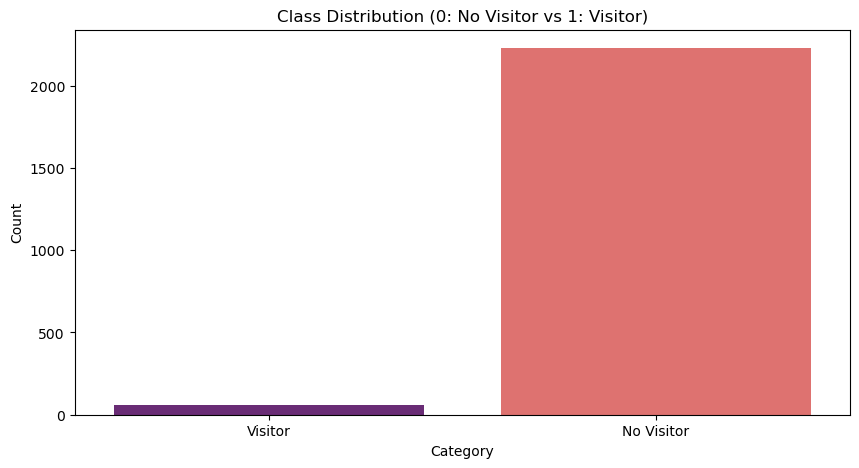

[*] Displaying 3 random samples per class...


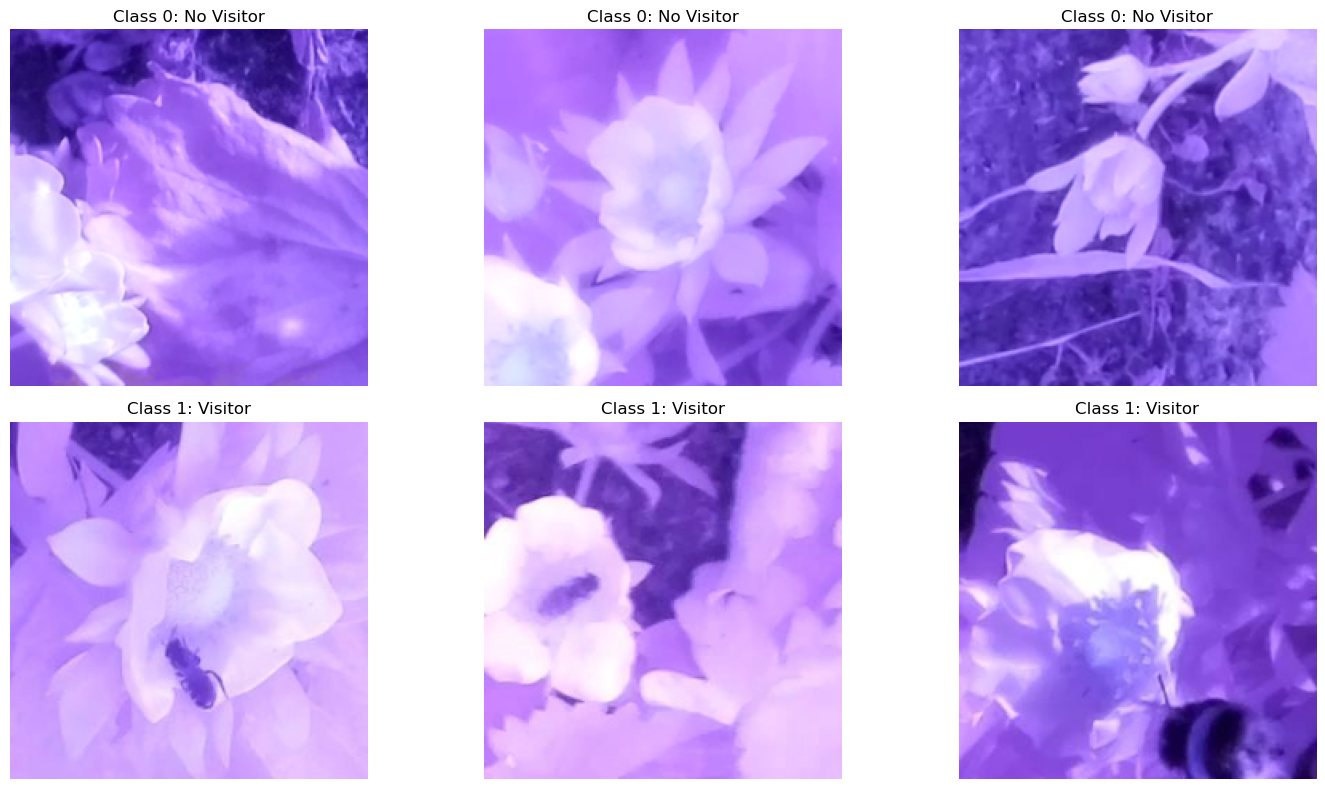

[*] Computing PCA on Raw Pixels...


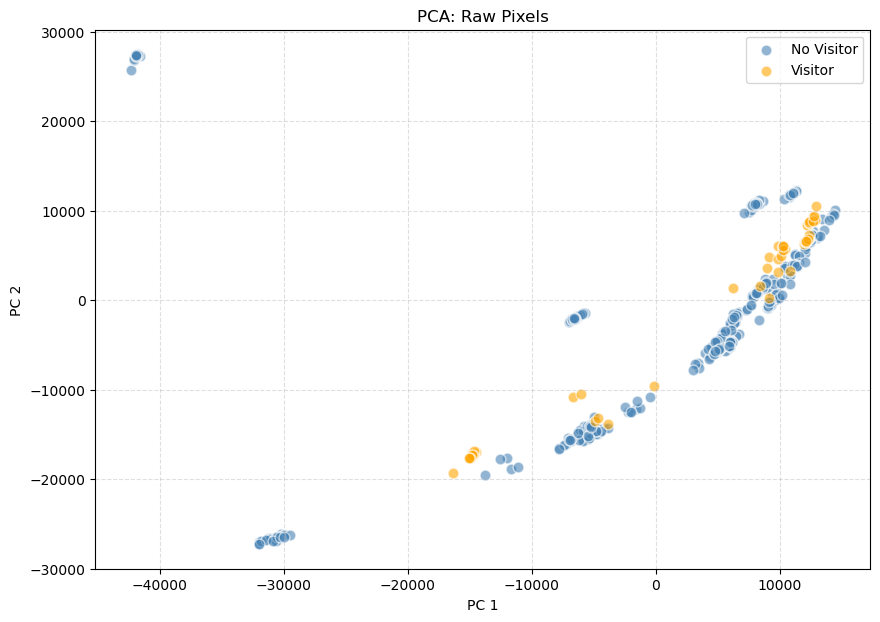

Extracting HOG (RGB): 100%|██████████| 2291/2291 [00:20<00:00, 111.01it/s]


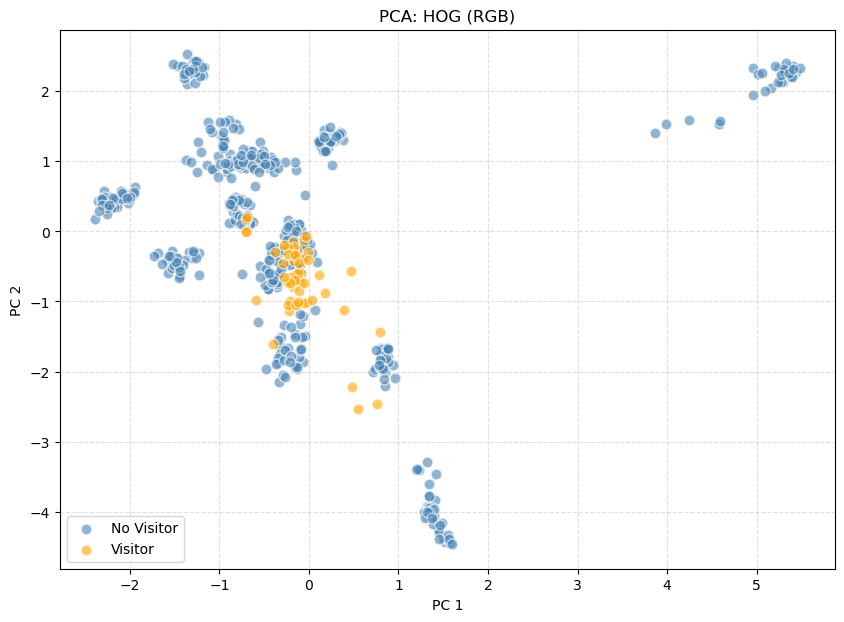

Extracting HOG (Grayscale): 100%|██████████| 2291/2291 [00:07<00:00, 302.85it/s]


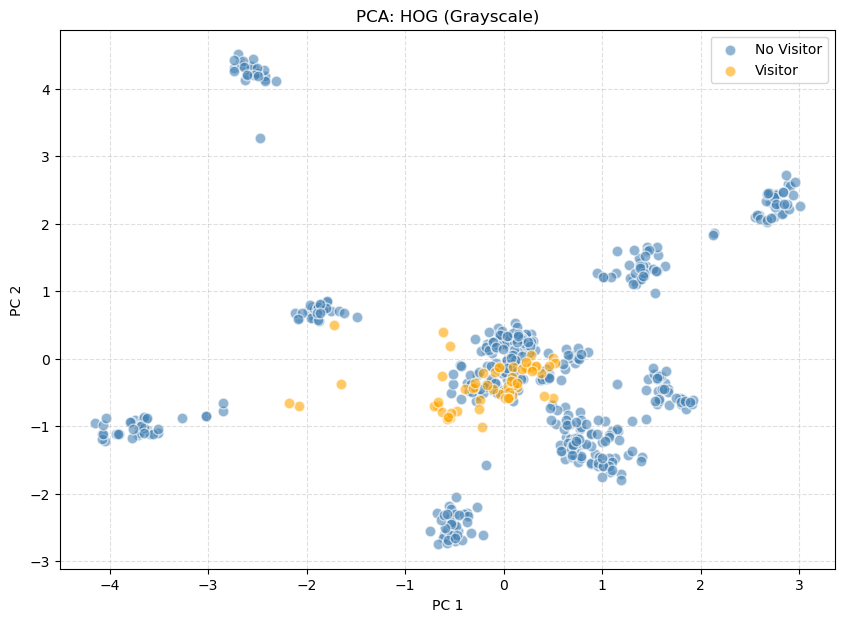

Extracting Multi-scale HOG (RGB): 100%|██████████| 2291/2291 [00:27<00:00, 83.80it/s]


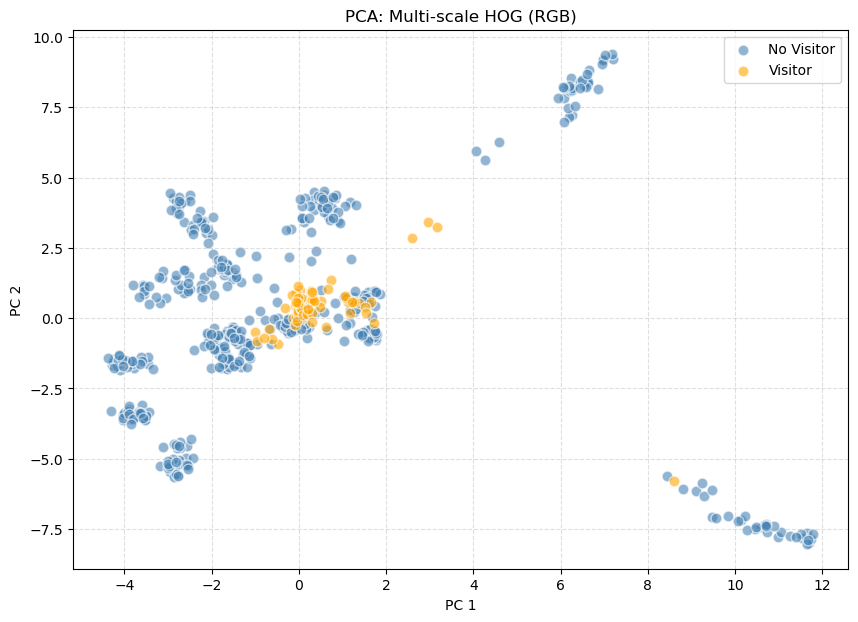

Extracting Multi-scale HOG (Grayscale): 100%|██████████| 2291/2291 [00:19<00:00, 116.96it/s]


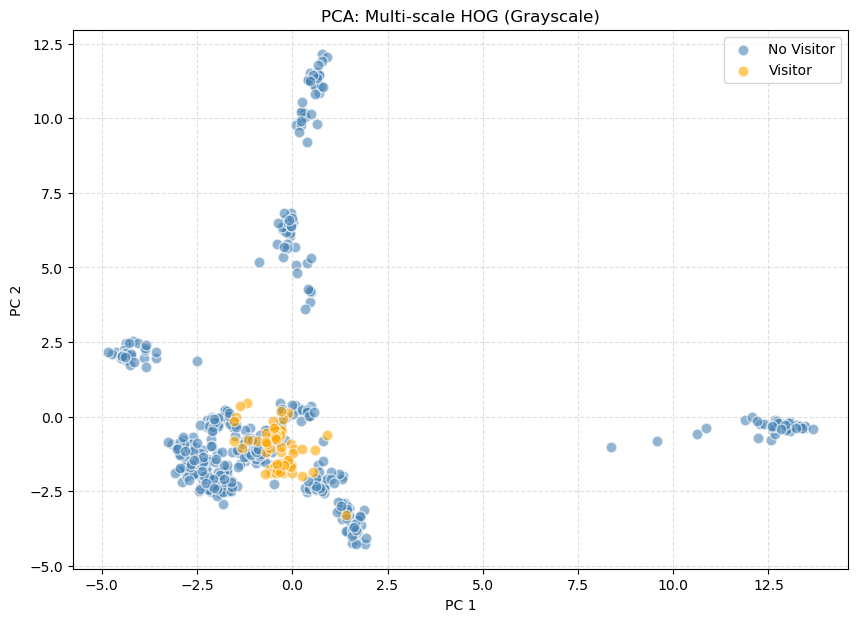

In [6]:
viz = Visualize(data_manager, n_per_class=500, n_imgs=3)
viz.run_all()

We notice a high imbalance between classes, with over 97% "No Visitors" and less than 3% "Visitors". This problem will have to be adressed later in the training and scoring.

The PCA on raw pixels shows that both classes overlap, probably due to the background of the images (the flowers) being predominant. We see a few cluster but they do not appear as class clusters. Therefore raw pixels seem like a really bad way to perform our classification.

The PCA on HOG shows more clusters and a bit of separation between both classes. Many clusters for class Visitor is normal as they represent different insects, but some No Visitor images also have their own cluster. We could pin this on angles and colors of the images. Still, HOG looks better than raw pixels for a classification task as both classes seems more defined and we can notice some separation.

The PCA on the grayfilter applied to HOG did not reveal any better separation than HOG alone and did not show better preliminary results. We can notice two well defined clusters, but most points from class 1 overlap with the class 0, more than without the gray filter, making it harder for classification.

The PCA with the multiscale HOG showed promising results with more elongation along the axis, and some clusters being well defined. Though during training we couldn't find any improvement, and it made the model bigger (the features vector is bigger) so less resources efficient. The grayfilter on the multiscale didn't change much things.

# 3 - Training
In this section, we transition from raw image data to a structured machine learning pipeline. We implement an XGBoost Classifier coupled with Histogram of Oriented Gradients (HOG) to establish a robust and high-performance baseline for pollinator detection.

## Feature Extraction: Why HOG?
Instead of feeding raw pixels directly into the model, which is computationally expensive and sensitive to lighting changes, we use HOG (Histogram of Oriented Gradients). HOG is often considered a spiritual ancestor to Convolutional Neural Networks (CNNs). While a CNN learns its own filters to detect edges and shapes, HOG uses fixed mathematical gradients to describe the "structure" and "shape" of objects.

Unlike deep learning models that require GPUs, HOG is extremely light. It captures the essential geometry of an insect (wings, legs, body orientation) while ignoring redundant color noise. It remains fast enough to run on a standard laptop. We tried a single scale HOG and a multiscale HOG, which is more greedy but could help capture more details.
 
## The Model: Why XGBoost?
After initial testing with Random Forest, we opted for XGBoost (Extreme Gradient Boosting) to handle the complexity of our dataset Unlike Random Forest, where trees are built independently, XGBoost builds trees sequentially. Each new tree is specifically designed to correct the errors made by the previous ones. This makes it significantly more effective at capturing subtle patterns in the HOG features that a Random Forest might miss.

With a "Visitor" class of only ~2.7%, standard models often struggle. We use the scale_pos_weight parameter, which mathematically penalizes the model more heavily for misclassifying an insect than for misclassifying a flower. This "aggressive" focus on the minority class is key to breaking the 0.5 balanced accuracy ceiling (where the model only predicts the class 0).

XGBoost includes $L1$ and $L2$ regularization, which helps prevent the model from "memorizing" the training images (overfitting), ensuring it performs better on new, unseen videos. By using tree_method='hist', XGBoost bins the HOG features into discrete bins, making the training process faster and less memory-intensive than traditional tree-based methods, even with large feature vectors.

## What We Are Doing
We have built a dynamic pipeline that allows for Hyperparameter Optimization on two levels: 

HOG Tuning: Finding the right "resolution" (pixels per cell) and orientation to ensure the model can distinguish an insect from a petal.

XGBoost Tuning: Optimizing the hyperparameters to find the perfect balance between detecting every insect and avoiding false alarms. We trained it by phases by training first the hyperparameters related to the structure, then the ones related to the learning, then to the regularization and finally by the sampling/stochatiscity. Note that RandomizedSearch is good to find a strong base set for your hyperparameters. Then some of them might need manual adjustments. We discuss some of them and give you some hints in the results part of this section, up to you to be smart about it and understand which hyperparameters control which behavior of the model.

We also compared two oversampling methods (random oversampling and SMOTE) versus increasing scale_pos_weight. SMOTE takes two points from the minority class and creates a new one at the center of the line between these points. This method can be good when classes are organized in clusters, here we don't expect much from it as our classes are not well separated. Random Oversampler just duplicates some points, which is expected to work better than SMOTE.

Finally, we trained the prediction threshold. Our model gives for each example the probability of being an insect. By default, the model predicts "Insects" if the probability is > 0.5. We shift this threshold between 0.1 and 0.6, because the model could tend to be very sure that there's in no insect, but could hesitate to predict insect to avoid being penalized, therefore lowering this threshold is promising.

This approach provides a lightweight baseline. It respects the constraints of a standard computer while delivering a performance benchmark that competes with much heavier architectures.

## Running time
The running time to train one model with 10% of the dataset is about 30 seconds (we are talking about one model, it doesn't include any cross-validation in the train method).

HOG features extraction is about 20 seconds.

The running time to train one model with 100% of the dataset is about 6 minutes (we are talking about one model, it doesn't include any cross-validation in the train method).

HOG features extraction is about 6 minutes.

We parallelized all these steps for you properly. Running times are given from our machine, times might differ from one machine to another.

In [7]:
class Train:
    def __init__(self, data_manager, grayscale=False, multiscale=False, oversampling='random', ratio=0.1, threshold=0.5):
        """
        Initializes pipeline and triggers HOG extraction immediately.
        """
        self.data = data_manager
        self.X_train_features = None 
        self.y_train = None

        # Parameters for parallelization
        try:
            self.n_cpus = len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else multiprocessing.cpu_count()
        except:
            self.n_cpus = 1
        print(f"[*] Detected {self.n_cpus} CPU cores for parallel processing.")
        self.cv3_jobs = max(self.n_cpus // 3, 1)
        self.cv5_jobs = max(self.n_cpus // 5, 1)

        # Actual hyperparameters are for 10% of the dataset, the ones for 100% are commented out
        # Parameters for XGBoost
        self.model = XGBClassifier(
            n_estimators=250, # 1500
            max_depth=5, # 15
            learning_rate=0.03, # 0.005 
            subsample=0.8,         
            colsample_bytree=0.8, # 0.6
            scale_pos_weight=10,
            min_child_weight=5, # 15
            gamma=0.5,  
            reg_alpha=0.1, # 1
            reg_lambda=1.0, # 0.1
            tree_method='hist',
            random_state=42,
            n_jobs=self.n_cpus,
            enable_categorical=False,
            max_delta_step=1, # 0 
        )

        # Parameters for HOG
        self.best_h_orient = 9
        self.best_h_pix = (16, 16)
        self.best_h_block = (1, 1)
        self.best_h_transform_sqrt = False
        self.grayscale = grayscale
        self.multiscale = multiscale
        # orientation, pixels_per_cell, cells_per_block, transform_sqrt
        self.s1_config = (12, (16, 16), (1, 1), False)
        self.s2_config = (9, (8, 8), (1, 1), False)

        # Threshold for classification
        self.threshold = threshold

        # Parameters for oversampling
        self.oversampling = oversampling
        self.ratio = ratio
        
        self.prepare_data()

    # --- Parallel Helpers ---
    def _process_single(self, img):
        """Helper for parallel single-scale extraction."""
        img_proc = rgb2gray(img) if self.grayscale else img
        c_axis = None if self.grayscale else -1
        return hog(img_proc, orientations=self.best_h_orient, 
                   pixels_per_cell=self.best_h_pix, cells_per_block=self.best_h_block, 
                   transform_sqrt=self.best_h_transform_sqrt, channel_axis=c_axis)

    def _process_multi(self, img):
        """Helper for parallel multi-scale extraction."""
        img_proc = rgb2gray(img) if self.grayscale else img
        c_axis = None if self.grayscale else -1
        h1 = hog(img_proc, orientations=self.s1_config[0], pixels_per_cell=self.s1_config[1],
                    cells_per_block=self.s1_config[2], transform_sqrt=self.s1_config[3], channel_axis=c_axis)
        h2 = hog(img_proc, orientations=self.s2_config[0], pixels_per_cell=self.s2_config[1],
                 cells_per_block=self.s2_config[2], transform_sqrt=self.s2_config[3], channel_axis=c_axis)
        return np.concatenate([h1, h2])

    def extract_hog(self):
        """
        Extracts HOG features from images with progress bar.
        """
        # Parallel extraction across all CPU cores
        features_list = Parallel(n_jobs=self.n_cpus)(
            delayed(self._process_single)(img) for img in tqdm(self.data.X_train, desc="Extracting HOG Features")
        )
        return np.array(features_list)

    def extract_hog_multiscale(self):
        """
        Multi-scale HOG with controlled complexity.
        Designed to keep computation reasonable while
        capturing fine insect-level details.
        """
        # Parallel extraction across all CPU cores
        features_list = Parallel(n_jobs=self.n_cpus)(
            delayed(self._process_multi)(img) for img in tqdm(self.data.X_train, desc="Extracting Multi-scale HOG")
        )
        return np.array(features_list)

    def prepare_data(self):
        """
        Prepares training data by extracting HOG features.
        Uses a dynamic naming convention for caching based on HOG parameters.
        """
        # Cache filename based on configuration
        mode = "multi" if self.multiscale else "single"
        gray = "gray" if self.grayscale else "rgb"
        train_size = len(self.data.X_train)
        
        if not self.multiscale:
            params = f"o{self.best_h_orient}_p{self.best_h_pix[0]}_b{self.best_h_block[0]}_sqrt{self.best_h_transform_sqrt}"
        else:
            params = f"s1-o{self.s1_config[0]}p{self.s1_config[1][0]}_s2-o{self.s2_config[0]}p{self.s2_config[1][0]}"

        filename = f"train_hog_{mode}_{gray}_n{train_size}_{params}.npy"
        cache_file = os.path.join(self.data.data_dir, filename)

        # Check if cache exists
        if os.path.exists(cache_file):
            print(f"[OK] Loading Train HOG features from cache: {cache_file}")
            self.X_train_features = np.load(cache_file)
        else:
            print(f"[*] Cache not found. Extracting HOG features from {train_size} images...")
            if self.multiscale:
                self.X_train_features = self.extract_hog_multiscale()
            else:
                self.X_train_features = self.extract_hog()
            
            print(f"[*] Saving Train HOG features to cache: {cache_file}")
            np.save(cache_file, self.X_train_features)

        self.y_train = self.data.y_train
        
        print(f"[OK] Ready to train on {self.X_train_features.shape[0]} samples.")
        print(f"[*] Feature vector size: {self.X_train_features.shape[1]}")

    def tune_parameters(self, phase=1, n_iter=8):
        """
        Runs Grid Search to exhaustively find the best hyperparameters.
        """
        if self.X_train_features is None:
            self.prepare_data()

        # Mapping phases to specific parameter grids
        grids = {
            1: {
                'max_depth': [3, 5, 7],
                'min_child_weight': [5, 10, 15],
                'gamma': [0, 0.5, 1],
                'scale_pos_weight': [3, 5, 10, 20],
                'max_delta_step': [0, 1]
            },
            2: {
                'learning_rate': [0.005, 0.01, 0.05],
                'n_estimators': [500, 1000, 1500]
            },
            3: {
                'reg_alpha':  [0, 0.1, 1],
                'reg_lambda': [1, 5, 10]
            },
            4: {
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        }

        if phase not in grids:
            print(f"[!] Phase {phase} not recognized. Available phases: {list(grids.keys())}")
            return
        param_grid = grids.get(phase, grids[1])

        print(f"[*] Starting RandomizedSearchCV (Phase {phase})...")
        # n_iter=8 will make 24 models, with parallel jobs this should take about 4 hours on 100% of the data
        # We discourage you to run GridSearchCV
        self.model.set_params(n_jobs=1) # Avoid nested parallelism
        search = RandomizedSearchCV(
            self.model, 
            param_distributions=param_grid, 
            n_iter=n_iter,              
            cv=3,
            scoring='f1',
            n_jobs=self.n_cpus,                     
            verbose=2,
            random_state=42
        )

        search.fit(self.X_train_features, self.y_train)
        self.model = search.best_estimator_
        self.model.set_params(n_jobs=self.n_cpus)
        
        print(f"[✔] Best Parameters found: {search.best_params_}")
        print(f"[✔] Best CV F1 Score: {search.best_score_:.4f}")

    def tune_hog_settings(self):
        """
        Finds the best HOG parameters for Single-scale mode.
        """
        hog_grid = [
            # {'pix': (8, 8),   'orient': 6, 'block': (1, 1)},
            # {'pix': (8, 8),   'orient': 9,  'block': (1, 1)},
            # {'pix': (8, 8),   'orient': 12, 'block': (1, 1)},
            {'pix': (12, 12),   'orient': 6, 'block': (1, 1)},
            {'pix': (12, 12),   'orient': 9, 'block': (1, 1)},
            {'pix': (16, 16), 'orient': 6, 'block': (1, 1)},
            {'pix': (16, 16), 'orient': 9,  'block': (1, 1)},
            # {'pix': (16, 16), 'orient': 12, 'block': (1, 1)},
            # {'pix': (32, 32), 'orient': 6, 'block': (1, 1)}
            # {'pix': (32, 32), 'orient': 9,  'block': (1, 1)},
            # {'pix': (32, 32), 'orient': 12, 'block': (1, 1)},   
        ]
        
        best_score = (0, 0)
        best_params = None
        
        print(f"[*] Tuning HOG (Grayscale={self.grayscale})...")
        for config in hog_grid:
            print(f"--- Testing: {config} ---")
            self.best_h_pix = config['pix']
            self.best_h_orient = config['orient']
            self.best_h_block = config['block']
            
            X_feats = self.extract_hog()
            
            self.model.set_params(n_jobs=self.cv3_jobs) # Avoid nested parallelism
            cv_results = cross_validate(self.model, X_feats, self.data.y_train, 
                                        cv=3, scoring=['balanced_accuracy', 'f1'], n_jobs=self.n_cpus)
            self.model.set_params(n_jobs=self.n_cpus)
            
            mean_f1 = cv_results['test_f1'].mean()
            mean_ba = cv_results['test_balanced_accuracy'].mean()
            std_f1 = cv_results['test_f1'].std()
            std_ba = cv_results['test_balanced_accuracy'].std()
            print(f"Result (Balanced Acc): {mean_ba:.4f} ± {std_ba:.4f}")
            print(f"Result (F1): {mean_f1:.4f} ± {std_f1:.4f}")
            
            if mean_f1 > best_score[0]:
                best_score = (mean_f1, mean_ba)
                best_std = (std_f1, std_ba)
                best_params = config

        self.best_h_orient = best_params['orient']
        self.best_h_pix = best_params['pix']
        self.best_h_block = best_params['block']
        print(f"\n[✔] Best Single-Scale: {best_params} (Score F1: {best_score[0]:.4f} ± {best_std[0]:.4f}) (Balanced Acc: {best_score[1]:.4f} ± {best_std[1]:.4f})")
        self.prepare_data()

    def tune_multiscale_settings(self):
        """
        Tunes multi-scale HOG parameters.
        """
        multi_grid = [
            {'s1': (12, (16, 16)), 's2': (9, (8, 8))},  
            {'s1': (9, (16, 16)), 's2': (6, (8, 8))},  
            # {'s1': (12, (32, 32)),  's2': (9, (16, 16))},  
            # {'s1': (9, (32, 32)), 's2': (6, (16, 16))},
        ]
        
        best_score = (0, 0)
        best_config = None
        
        print(f"[*] Tuning Multiscale (Grayscale={self.grayscale})...")
        for config in multi_grid:
            print(f"--- Testing Combo: S1={config['s1']} + S2={config['s2']} ---")
            X_feats = self.extract_hog_multiscale()
            
            self.model.set_params(n_jobs=self.cv3_jobs) # Avoid nested parallelism
            cv_results = cross_validate(self.model, X_feats, self.data.y_train, 
                                        cv=3, scoring=['balanced_accuracy', 'f1'], n_jobs=self.n_cpus)
            self.model.set_params(n_jobs=self.n_cpus)
            
            mean_f1 = cv_results['test_f1'].mean()
            mean_ba = cv_results['test_balanced_accuracy'].mean()
            std_f1 = cv_results['test_f1'].std()
            std_ba = cv_results['test_balanced_accuracy'].std()
            print(f"Result (Balanced Acc): {mean_ba:.4f} ± {std_ba:.4f}")
            print(f"Result (F1): {mean_f1:.4f} ± {std_f1:.4f}")
            
            if mean_f1 > best_score[0]:
                best_score = (mean_f1, mean_ba)
                best_std = (std_f1, std_ba)
                best_config = config

        self.s1_config = best_config['s1']
        self.s2_config = best_config['s2']
        print(f"\n[✔] Best Multi-Scale: {best_config} (Score F1: {best_score[0]:.4f} ± {best_std[0]:.4f}) (Balanced Acc: {best_score[1]:.4f} ± {best_std[1]:.4f})")
        self.prepare_data()

    def tune_threshold(self, thresholds=None):
        """
        Finds the optimal probability threshold using cross-validation to maximize F1-Score.
        """
        if thresholds is None:
            thresholds = np.arange(0.1, 0.6, 0.05)
            
        if self.X_train_features is None:
            self.prepare_data()

        print(f"[*] Tuning threshold via 3-fold Cross-Validation...")
        
        # Get probabilities via cross-validation
        # This allows obtaining a probability for each training set sample
        # as if it were in a test set (out-of-fold).
        self.model.set_params(n_jobs=self.cv3_jobs) # Avoid nested parallelism
        y_probs = cross_val_predict(
            self.model, 
            self.X_train_features, 
            self.y_train, 
            cv=3, 
            method='predict_proba', 
            n_jobs=self.n_cpus
        )[:, 1]
        self.model.set_params(n_jobs=self.n_cpus)

        best_f1 = -1
        best_ba = -1
        best_threshold = 0.5
        results = []

        # Test each threshold
        for thr in thresholds:
            y_pred = (y_probs >= thr).astype(int)
            f1 = f1_score(self.y_train, y_pred)
            ba = balanced_accuracy_score(self.y_train, y_pred)
            
            results.append((thr, f1, ba))
            
            if f1 > best_f1:
                best_f1 = f1
                best_ba = ba
                best_threshold = thr

        print(f"\n{'Threshold':<12} | {'F1-Score':<10} | {'Balanced Acc':<12}")
        print("-" * 40)
        for thr, f1, ba in results:
            mark = " <--" if thr == best_threshold else ""
            print(f"{thr:<12.3f} | {f1:<10.4f} | {ba:<12.4f}{mark}")

        print(f"\n[✔] Best Threshold found: {best_threshold:.3f} (F1: {best_f1:.4f}) (Balanced Acc: {best_ba:.4f})")
        self.threshold = best_threshold

    def train(self):
        """
        Trains the final model. 
        Performs a 5-fold Cross-Validation using the optimized threshold 
        to report realistic F1 and Balanced Accuracy scores before final fitting.
        """
        if self.X_train_features is None:
            self.prepare_data()

        X_final, y_final = self.X_train_features, self.y_train

        # Handle class imbalance with oversampling if requested
        if self.oversampling is not None:
            print(f"[*] Applying {self.oversampling} oversampling to reach ratio {self.ratio}...")
            current_ratio = np.sum(self.y_train == 1) / np.sum(self.y_train == 0)
            strategy = self.ratio / (1 - self.ratio)
            if strategy > current_ratio:
                if self.oversampling.lower() == 'smote':
                    sampler = SMOTE(sampling_strategy=strategy, random_state=42)
                elif self.oversampling.lower() == 'random':
                    sampler = RandomOverSampler(sampling_strategy=strategy, random_state=42)
                else:
                    print(f"[!] Unknown oversampling method: {self.oversampling}. Skipping oversampling.")
                    sampler = None
                if sampler is not None:
                    X_final, y_final = sampler.fit_resample(X_final, y_final)

        # We define helper functions that apply our optimized threshold to the probabilities
        def f1_at_threshold(y_true, y_probs, **kwargs):
            # y_probs will be the probabilities for the positive class (class 1)
            y_pred = (y_probs >= self.threshold).astype(int)
            return f1_score(y_true, y_pred)

        def ba_at_threshold(y_true, y_probs, **kwargs):
            y_pred = (y_probs >= self.threshold).astype(int)
            return balanced_accuracy_score(y_true, y_pred)

        # We wrap them into scikit-learn scorers. 
        # needs_proba=True tells cross_validate to pass probabilities instead of hard labels.
        custom_scorers = {
            'f1': make_scorer(f1_at_threshold, needs_proba=True),
            'balanced_accuracy': make_scorer(ba_at_threshold, needs_proba=True)
        }

        # Cross-Validation before final training
        print(f"[*] Performing 5-fold CV before final training (Threshold: {self.threshold:.3f})...")
        self.model.set_params(n_jobs=self.cv5_jobs) # Avoid nested parallelism
        cv_results = cross_validate(
            self.model, X_final, y_final, 
            cv=5, 
            scoring=custom_scorers, 
            n_jobs=self.n_cpus
        )
        self.model.set_params(n_jobs=self.n_cpus)
        
        # Extract means and standard deviations
        mean_f1 = cv_results['test_f1'].mean()
        std_f1 = cv_results['test_f1'].std()
        mean_ba = cv_results['test_balanced_accuracy'].mean()
        std_ba = cv_results['test_balanced_accuracy'].std()
        print(f"[CV RESULTS] Threshold: {self.threshold:.3f}")
        print(f" >> F1-Score:          {mean_f1:.4f} ± {std_f1:.4f}")
        print(f" >> Balanced Accuracy: {mean_ba:.4f} ± {std_ba:.4f}")

        # Final fit on the entire dataset
        print("[*] Training final model on the full provided dataset...")
        self.model.fit(X_final, y_final)
        print("[✔] Model trained successfully!")

        # Confusion Matrix on the training data
        print(f"[*] Generating final training confusion matrix (Threshold: {self.threshold:.3f})...")
        # Predict probabilities on the training data
        y_probs_final = self.model.predict_proba(X_final)[:, 1]
        y_pred_final = (y_probs_final >= self.threshold).astype(int)
        
        # Compute and plot Confusion Matrix
        cm = confusion_matrix(y_final, y_pred_final)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Visitor", "Visitor"])
        disp.plot(cmap='Blues', ax=ax, values_format='d')
        plt.title(f"Final Training Confusion Matrix (Threshold: {self.threshold:.3f})")
        plt.grid(False)
        plt.show()

[*] Detected 8 CPU cores for parallel processing.
[*] Cache not found. Extracting HOG features from 2291 images...


Extracting HOG Features: 100%|██████████| 2291/2291 [00:12<00:00, 179.47it/s]


[*] Saving Train HOG features to cache: data/train_hog_single_rgb_n2291_o9_p16_b1_sqrtFalse.npy
[OK] Ready to train on 2291 samples.
[*] Feature vector size: 1764
[*] Applying random oversampling to reach ratio 0.1...
[*] Performing 5-fold CV before final training (Threshold: 0.500)...
[CV RESULTS] Threshold: 0.500
 >> F1-Score:          0.7860 ± 0.1411
 >> Balanced Accuracy: 0.9635 ± 0.0246
[*] Training final model on the full provided dataset...
[✔] Model trained successfully!
[*] Generating final training confusion matrix (Threshold: 0.500)...


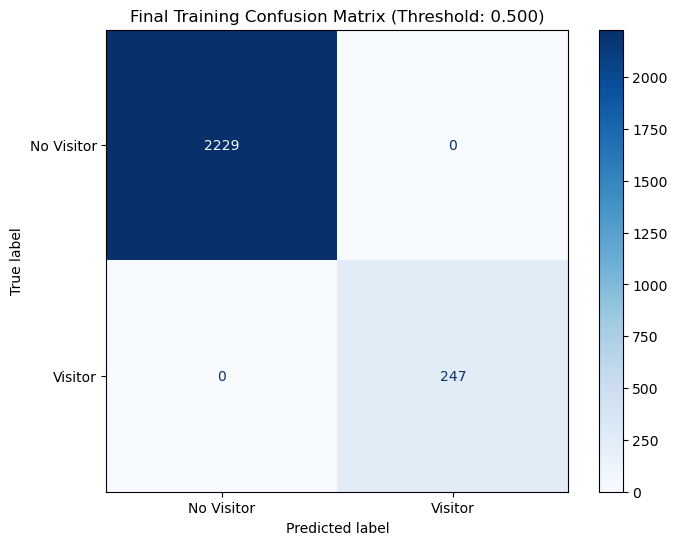

In [8]:
# Initialize Trainer with desired settings
trainer = Train(data_manager, grayscale=False, multiscale=False, oversampling='random', ratio=0.1)

# HoG Parameter Tuning
# trainer.tune_hog_settings()
# trainer.tune_multiscale_settings()

# Hyperparameter Tuning Phases
# for i in range(1, 5):
#     trainer.tune_parameters(phase=i)

# Threshold Tuning
# trainer.tune_threshold()

# Training the final model
trainer.train()

## Parameters Tuning Results (tested on the whole dataset):

### HOG parameters:
{'pix': (8, 8), 'orient': 9, 'block': (1, 1)}
- Result (Balanced Acc): 0.6047 ± 0.1083
- Result (F1): 0.1702 ± 0.1545

{'pix': (8, 8), 'orient': 6, 'block': (1, 1)}
- Result (Balanced Acc): 0.5963 ± 0.1054
- Result (F1): 0.1673 ± 0.1575

{'pix': (12, 12), 'orient': 6, 'block': (1, 1)}
- Result (Balanced Acc): 0.5860 ± 0.1125
- Result (F1): 0.1191 ± 0.1013

{'pix': (12, 12), 'orient': 9, 'block': (1, 1)}
- Result (Balanced Acc): 0.6374 ± 0.1314
- Result (F1): 0.1306 ± 0.0949

Testing different values for pix, orient and block allowed us to determine the best combination. We did not go too low in pix or too high values to keep a model efficient (decreasing pix, increasing orient or increasing block make the features vector bigger, therefore making the training longer). We notice a large standard deviation, due to the 3-fold split being severe and the hyperparameters of our XGBoost not yet being optimized. We prioritize F1-Score over balanced accuracy, and therefore selection pix=(8, 8), orient=9 and block=(1, 1). Note that to keep the model fast to run, we will reduce pix to (16, 16) that also shows great results.

### XGBoost Phase 1:

[✔] Best Parameters (Phase 1): {'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 10, 'scale_pos_weight': 5}

[✔] Best CV F1 Score: 0.2201

We later changed scale_pos_weight to experiment with different hyper parameters and with the following rule: when there is no False Positive (the model predicting 1 when it's 0), we can increase scale_pos_weigth. If we start to get False Positive (or already have too much), decreasing it will establish better scores. We also played with min_child_weight and max_depth, that go together and are strong hyperparameters to balance the True Positive and False Positive.

We noted that if you put transform_sqrt to true in the HOG, the model needs a higher value (about 35, which is the ratio class 0 over class 1) for scale_pos_weight than when using transform_sqrt=False. transform_sqrt=False is more promising, can detect more insects, but quickly turn aggressive into making False Positive. In this specific context, gaining 10 True Positives at the cost of 50 False Positives is actually a great trade-off. Given the extreme class imbalance (roughly 1 insect for every 36 no-insect samples), the model's ability to find the needle in the haystack is paramount. Since insects are so rare, catching a few more is worth the price of having to manually filter or tolerate more false alarms.

### XGBoost Phase 2:

[✔] Best Parameters (Phase 2): {'learning_rate': 0.005, 'n_estimators': 1500}

[✔] Best CV F1 Score: 0.2201

### XGBoost Phase 3:

[✔] Best Parameters (Phase 3): {'reg_alpha': 1, 'reg_lambda': 0.1}

[✔] Best CV F1 Score: 0.2210

### XGBoost Phase 4:

[✔] Best Parameters (Phase 4): {'colsample_bytree': 0.6, 'subsample': 0.8}

[✔] Best CV F1 Score: 0.2247

### Threshold:

[✔] Best Threshold found: 0.500 
(F1: 0.1112) (Balanced Acc: 0.6089)

You can then adjust the threshold by looking at the probabilities distribution for each class. For instance, on the graph below, you can see that around 0.4, there is a significant amount of class 1 (insects) that are missed by the default 0.5 threshold. Therefore, lowering the threshold to 0.4 might give you a better F1-Score: it will improve Recall (more True Positives) while slightly lowering Precision (more False Positives).

![best_model_probas.png](best_model_probas.png)

### Oversampling methods

For oversampling, we tried to resample the minority class with two methods to different proportions (10%, 15%, 20%, 30, 50%), by adjusting scale_pos_weight accordingly (for instance, if scale_pos_weight=55 when class 1 is 2.71% of the dataset, it becomes 15 with 10%, 8 with 20%, 5 for 30% and 3 for 50% etc., to be adjusted after observations).

After testing different rebalancing values and adjusting scale_pos_weight, SMOTE constantly decreased (by a lot) our performance, confirming what we thought about SMOTE being inefficient here because of the classes not being well separated, so the oversampling creates insects that are not real and confuse the model.

Random Oversampler showed great results and some improvements. With ratio=0.1 and scale_pos_weight=5 (max_delta_step=0), we peaked in balanced accuracy and F1-Score for 10% of the dataset, meaning that giving a bit more examples to the model while making it even more aggressive on the class 1 is a good strategy. Other resampling ratios didn't show better results (because of the few examples we have, too high ratios would duplicate too many times the same example to add good informations).

### Detecting More and Minimizing False Alarms

We tried to detect more insects by forcing some scale_pos_weigth, but noticed that we reached a cap where going up one more True Positive cost us a lot of False Positive, which was bad. We decided to introduce in our model the parameter max_delta_step=1 to constrain this, achieving a little rise in True Positive without a great cost in False Positive. The image below shows how scale_pos_weight reflects on the F1-Score. Too low and the model will just predict no insect for all examples, too high and it will predict too much insects (raising False Positive). The sweet spot is in between, where it predicts insects but don't hallucinate about seeing some insects when there's nothing.

![scale_pos_weight_optimization.png](scale_pos_weight_optimization.png)

### Final results

In training with 10% of the dataset, the crossval score peaked at:

- F1-Score:          0.7282 ± 0.2487
- Balanced Accuracy: 0.9325 ± 0.0668

In training with 100% of the dataset, the crossval score peaked at:

- F1-Score:          0.4927 ± 0.2180
- Balanced Accuracy: 0.8364 ± 0.1181


HINT: NOTE THAT THE MODEL TEND TO OVERFIT A LOT ON THE TRAIN SET AND GENERALIZE VERY POORLY, PAY ATTENTION TO THE REGULARIZATION TOOLS.

See hyperparameters below:


In [ ]:
# Hyperparameter on 10% of the dataset:
multiscale_10 = False
grayscale_10 = False
oversampling_10, ratio_10 = 'random', 0.1
threshold_10 = 0.5

model_10 = XGBClassifier( 
    n_estimators=250,  
    max_depth=5,  
    learning_rate=0.03, 
    subsample=0.8,      
    colsample_bytree=0.8,  
    scale_pos_weight=10,
    min_child_weight=5,
    max_delta_step=1,
    gamma=0.5,  
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    enable_categorical=False,
)

hog_10 = hog(any, orientations=12, pixels_per_cell=(16, 16), cells_per_block=(1, 1), transform_sqrt=False, channel_axis=-1)

# Hyperparameters on 100% of the dataset:
multiscale_100 = False
grayscale_100 = False
oversampling_100, ratio_100 = 'random', 0.1
threshold_100 = 0.5

model_100 = XGBClassifier(
        n_estimators=1500,      
        max_depth=15,            
        learning_rate=0.005,    
        subsample=0.8,         
        colsample_bytree=0.6,  
        scale_pos_weight=10,
        max_delta_step=1,
        min_child_weight=15,
        gamma=0.5,  
        reg_alpha=1.0,
        reg_lambda=0.1,
        tree_method='hist',
        random_state=42,
        n_jobs=-1,
        enable_categorical=False
    )

hog_100 = hog(any, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(1, 1), transform_sqrt=False, channel_axis=-1)

# 4 - Scoring

This section evaluates the trained model on unseen data using the X_test set from the data_manager. Testing on separate data is essential to verify the model's generalization capabilities and check for overfitting.

## Methodology:
Feature Extraction: Each test image is processed through the HOG algorithm using the trainer's optimized parameters to convert visual structures into a 1D feature vector compatible with the model.

Metric Selection: Standard accuracy is misleading due to the high class imbalance (~2.7% visitors). We use the following metrics instead:

Balanced Accuracy: Calculates the average recall for each class, giving equal importance to both majority and minority classes.

F1-Score: The harmonic mean of Precision and Recall, providing a balanced view of the model's performance specifically on the "Visitor" class. NOTE: This is the main metric of the challenge, the one you will be ranked on.

Confusion Matrix: A visual tool to identify the nature of errors, such as False Positives (misidentifying a flower as having an insect) or False Negatives (missing an actual insect).

In an imbalanced dataset, Balanced Accuracy prevents the model from appearing successful by simply guessing the majority class, as it calculates the average performance across both classes independently. Meanwhile, the F1-Score provides a single measure of reliability by balancing the trade-off between avoiding false alarms (Precision) and ensuring no actual visitors are missed (Recall).

In [9]:
class Score:
    def __init__(self, data_manager, trainer):
        """Initializes scoring pipeline and triggers HOG extraction on test set."""
        self.data = data_manager
        self.trainer = trainer
        self.results = {}
        self.cm = None
        self.X_test_features = None

        # Parameters for parallelization
        try:
            self.n_cpus = len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else multiprocessing.cpu_count()
        except:
            self.n_cpus = 1
        print(f"[*] Detected {self.n_cpus} CPU cores for parallel processing.")

        # Save cache filename based on configuration
        mode = "multi" if trainer.multiscale else "single"
        gray = "gray" if trainer.grayscale else "rgb"
        test_size = len(self.data.X_test)
        
        if not trainer.multiscale:
            params = f"o{trainer.best_h_orient}_p{trainer.best_h_pix[0]}_b{trainer.best_h_block[0]}_sqrt{trainer.best_h_transform_sqrt}"
        else:
            # Pour le multiscale, on résume les configs s1 et s2
            params = f"s1-o{trainer.s1_config[0]}p{trainer.s1_config[1][0]}_s2-o{trainer.s2_config[0]}p{trainer.s2_config[1][0]}"

        filename = f"test_hog_{mode}_{gray}_n{test_size}_{params}.npy"
        self.cache_file = os.path.join(self.data.data_dir, filename)

        if os.path.exists(self.cache_file):
            print(f"[OK] Loading Test HOG features from cache: {self.cache_file}")
            self.X_test_features = np.load(self.cache_file)
        else:
            if trainer.multiscale:
                self.X_test_features = self.extract_hog_test_multiscale()
            else:
                self.X_test_features = self.extract_hog_test()
            
            print(f"[*] Saving Test HOG features to cache: {self.cache_file}")
            np.save(self.cache_file, self.X_test_features)
    
    # --- Parallel Helpers ---
    def _process_single(self, img):
        """Helper for parallel single-scale extraction on test set."""
        img_proc = rgb2gray(img) if self.trainer.grayscale else img
        c_axis = None if self.trainer.grayscale else -1
        return hog(img_proc, 
                   orientations=self.trainer.best_h_orient, 
                   pixels_per_cell=self.trainer.best_h_pix, 
                   cells_per_block=self.trainer.best_h_block, 
                   transform_sqrt=self.trainer.best_h_transform_sqrt, 
                   channel_axis=c_axis)

    def _process_multi(self, img):
        """Helper for parallel multi-scale extraction on test set."""
        img_proc = rgb2gray(img) if self.trainer.grayscale else img
        c_axis = None if self.trainer.grayscale else -1

        # Synchronize multi-scale configs from trainer if they exist
        s1 = getattr(self.trainer, 's1_config', (12, (16, 16), (1, 1), False))
        s2 = getattr(self.trainer, 's2_config', (9, (8, 8), (1, 1), False))

        h1 = hog(img_proc, orientations=s1[0], pixels_per_cell=s1[1],
                 cells_per_block=s1[2], transform_sqrt=s1[3], channel_axis=c_axis)
        
        h2 = hog(img_proc, orientations=s2[0], pixels_per_cell=s2[1],
                 cells_per_block=s2[2], transform_sqrt=s2[3], channel_axis=c_axis)
        
        return np.concatenate([h1, h2])

    # --- Extraction Methods ---
    def extract_hog_test(self):
        """
        Extracts HOG features from the test set using parallel processing.
        """
        print(f"[*] Extracting HOG features from {len(self.data.X_test)} test images (Parallel)...")
        features = Parallel(n_jobs=self.n_cpus)(
            delayed(self._process_single)(img) for img in tqdm(self.data.X_test, desc="Test HOG")
        )
        return np.array(features)

    def extract_hog_test_multiscale(self):
        """
        Extracts Multi-scale HOG features from the test set using parallel processing.
        """
        print(f"[*] Extracting Multi-scale HOG from {len(self.data.X_test)} test images (Parallel)...")
        features = Parallel(n_jobs=self.n_cpus)(
            delayed(self._process_multi)(img) for img in tqdm(self.data.X_test, desc="Test Multi-HOG")
        )
        return np.array(features)

    def compute_score(self):
        """
        Computes predictions and scores using a custom probability threshold.
        """
        try:
            check_is_fitted(self.trainer.model)
        except NotFittedError:
            print("[!] Trainer model is not fitted. Please train the model before scoring.")
            return None
        
        if self.X_test_features is None:
            if self.trainer.multiscale:
                self.X_test_features = self.extract_hog_test_multiscale()
            else:
                self.X_test_features = self.extract_hog_test()
        
        # Predicting with probabilities for threshold control
        print(f"[*] Predicting on test set with threshold {self.trainer.threshold}...")
        y_probs = self.trainer.model.predict_proba(self.X_test_features)[:, 1]
        y_pred = (y_probs >= self.trainer.threshold).astype(int)
        y_true = self.data.y_test
        
        # Confusion Matrix      
        self.cm = confusion_matrix(y_true, y_pred)
        
        # Metrics Calculation
        self.results['Threshold'] = self.trainer.threshold
        self.results['Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
        self.results['F1 Score'] = f1_score(y_true, y_pred, pos_label=1)
        
        self._display_results()
        
        return self.results

    def _display_results(self):
        """Displays the metrics table and the confusion matrix."""
        print("="*40)
        print(f"{'EVALUATION METRICS':^40}")
        print("="*40)
        for metric, value in self.results.items():
            print(f"{metric:<20} : {value:.4f}")
        print("="*40)

        print("\n[*] Plotting Confusion Matrix...")
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, display_labels=["No Visitor", "Visitor"])
        disp.plot(cmap='Blues', ax=ax, values_format='d')
        plt.title(f"Confusion Matrix (Threshold: {self.results.get('Threshold', 0.5)})")
        plt.grid(False)
        plt.show()

[*] Detected 8 CPU cores for parallel processing.
[*] Extracting HOG features from 776 test images (Parallel)...


Test HOG: 100%|██████████| 776/776 [00:16<00:00, 48.44it/s]


[*] Saving Test HOG features to cache: data/test_hog_single_rgb_n776_o9_p16_b1_sqrtFalse.npy
[*] Predicting on test set with threshold 0.5...
           EVALUATION METRICS           
Threshold            : 0.5000
Balanced Accuracy    : 0.6035
F1 Score             : 0.0733

[*] Plotting Confusion Matrix...


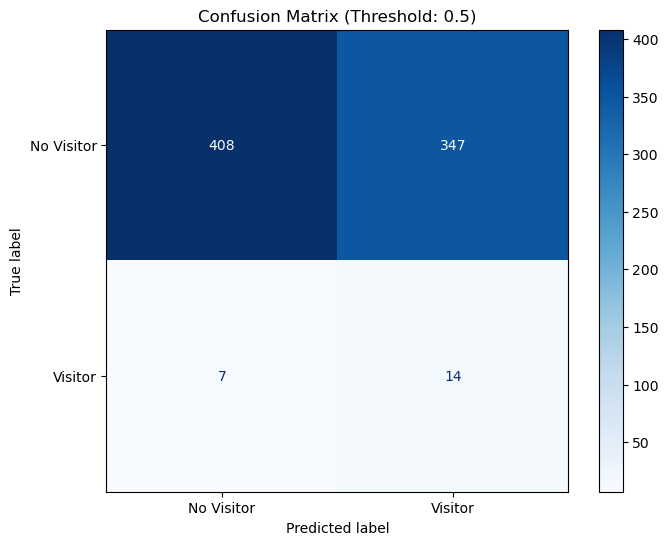

{'Threshold': 0.5,
 'Balanced Accuracy': 0.603532008830022,
 'F1 Score': 0.07329842931937172}

In [10]:
score = Score(data_manager, trainer)
score.compute_score()

## Final results

### 10% of the dataset
For 10% of the whole dataset, with the simple scale RGB HOG with oversampling (the model we found was the best during training), our balanced accuracy reached 0.6781 and our F1-score 0.5128. This shows a big overfitting on the train set (-0.2544 in balanced accuracy and -0.2154 in F1-score), which is typical of XGBoost and imbalanced datasets. Future improvements could be on the regularization to decrease overfitting, or force the model to detect more insects.

### 100% of the dataset 
For 100% of the whole dataset, with the simple scale RGB HOG with oversampling (the model we found was the best during training), our balanced accuracy reached 0.6681 and our F1-score 0.3311. This shows a quite important overfitting on the train set (-0.1683 in balanced accuracy and -0.1616 in F1-score), which is typical of XGBoost and imbalanced datasets. Future improvements could be on the regularization to decrease overfitting, or force the model to detect more insects.

# 4.5 Full Parameters Optimization (just as an example, do not run)

In [ ]:
# Pipeline Execution and Logging for Hyperparameter Tuning (do not use fully, it's a long one)
# Was used to generate the final optimized model and log results (on 10% of data for speed)

log_file = "hog_optimization_results.txt"
with open(log_file, "w") as f:
    f.write("=== HOG OPTIMIZATION LOG ===\n\n")

for i in range(0, 2): # 0 = Single-scale, 1 = Multi-scale
    for j in [False, True]: # Grayscale options
        trainer = Train(data_manager, grayscale=j, multiscale=bool(i))
        
        # Tuning HOG settings
        if i == 0:
            mode = "Single-Scale"
            trainer.tune_hog_settings()
        else:
            mode = "Multi-Scale"
            trainer.tune_multiscale_settings()
            
        # Tuning XGBoost phases
        for p in range(1, 5):
            trainer.tune_parameters(phase=p)

        # Tuning threshold
        trainer.tune_threshold()
            
        # Training
        trainer.train(oversampling=None)

        # Summary data
        relevant_params = [
            'n_estimators', 'max_depth', 'learning_rate', 'subsample', 
            'colsample_bytree', 'scale_pos_weight', 'min_child_weight', 
            'max_delta_step', 'gamma', 'reg_alpha', 'reg_lambda'
        ]
        all_params = trainer.model.get_params()
        filtered_params = {k: all_params[k] for k in relevant_params if k in all_params}
        
        hog_info = (f"Orient={trainer.best_h_orient}, Pix={trainer.best_h_pix}, Block={trainer.best_h_block}" 
                    if not i else f"S1={trainer.s1_config}, S2={trainer.s2_config}")
        
        # Logging results
        output = (
            f"\n{'='*40}\n"
            f"[Summary] Mode: {mode} | Grayscale: {j}\n"
            f"HOG Settings: {hog_info}\n"
            f"Final Model Params: {filtered_params}\n"
            f"Optimized Threshold: {trainer.threshold}\n"
        )
        print(output)
        
        with open(log_file, "a") as f:
            f.write(output)

        # Scoring
        score = Score(data_manager, trainer)
        res = score.compute_score()
            
        score_line = (
            f"F1: {res['F1 Score']:.4f} | Balanced Acc: {res['Balanced Accuracy']:.4f}\n"
            f"{'-'*40}\n"
        )
        print(score_line)
        with open(log_file, "a") as f:
            f.write(score_line)
                
        # Cleanup
        del trainer
        del score
        gc.collect()

# 5 - Prepare submission for Codabench

***

In this section you can prepare a zip of your code to make your submission. You just have to execute the cell and a zip file will be created automatically. Be sure to have a `model.py` in the folder `sample_code_submission`.

The model.py file should define a class named 'Model' with the following interface::
- \_\_init\_\_(self)
- fit(self, X, y)
- predict(self, X)

When you submit your code to codabench, this 'Model' class will be instantiated, trained, and evaluated.
You can have all other helper functions and classes in this file as needed, 
but only these three methods will be called by the evaluation framework.

***

In [11]:
import os
import zipfile

class Submission:
    def __init__(self, submission_dir, zip_file_name):
        self.submission_dir = submission_dir
        self.zip_file_name = zip_file_name
        if not os.path.exists(self.submission_dir):
            os.makedirs(self.submission_dir, exist_ok=True)

    def zip_submission(self, source_dir="sample_code_submission"):
        """
        Zips the model.py file from the source directory.
        """
        zip_path = os.path.join(self.submission_dir, self.zip_file_name)
        target_file = "model.py"
        source_path = os.path.join(source_dir, target_file)

        if not os.path.exists(source_path):
            print(f"[ERROR] {target_file} not found in {source_dir}!")
            return

        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            zf.write(source_path, arcname=target_file)
            print(f"[✔] Zipping {target_file} from {source_dir}")
                
        print(f"[OK] Code submission ZIP ready: {zip_path}")

In [13]:
import datetime
import os

# --- CONFIGURATION ---
SOURCE_FOLDER = "sample_code_submission"  # Where your model.py is located
TARGET_FOLDER = "./submission"       # Where the ZIP will be saved
MODEL_FILE = "model.py"

# --- ZIP GENERATION ---
print(f"[*] Preparing code submission...")

# Create a unique name for the submission file
timestamp = datetime.datetime.now().strftime('%y-%m-%d-%H-%M')
zip_file_name = f"Submission_Code_{timestamp}.zip"

# Initialize the Submission helper
submission = Submission(submission_dir=TARGET_FOLDER, zip_file_name=zip_file_name)

# Simply zip the model.py file
# No training, no data loading, just packaging the 'brain'
submission.zip_submission(source_dir=SOURCE_FOLDER)

print(f"\n[DONE] Submission package created: {os.path.join(TARGET_FOLDER, zip_file_name)}")
print("[!] This ZIP contains your 'model.py' and is ready for Codabench.")

[*] Preparing code submission...
[✔] Zipping model.py from sample_code_submission
[OK] Code submission ZIP ready: ./submission/Submission_Code_26-01-31-15-57.zip

[DONE] Submission package created: ./submission/Submission_Code_26-01-31-15-57.zip
[!] This ZIP contains your 'model.py' and is ready for Codabench.
